# 👣 Track the coupled fields between CICE6 and WW3

In [67]:
import intake
from intake import cat
# from datatree import DataTree, map_over_subtree

from dask.distributed import Client
import glob
import xarray as xr
import numpy as np
from datetime import timedelta
import cf_xarray as cfxr
import xesmf
import re

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean.cm as cmo
import matplotlib.lines as mlines
import cartopy.feature as cft
import seaborn as sns
from cycler import cycler

# Import my functions
functions_path = os.path.abspath("/home/566/nd0349/access-om3-analysis/functions")
if functions_path not in sys.path:
    sys.path.append(functions_path)
from get_files import *
from plot_settings import *
from fstd import *
from attenuation_models import *
test()

colors = sns.color_palette("colorblind")
plt.rcParams['axes.prop_cycle'] = cycler(color=colors)
𝜋 = np.pi
PUNY = 1e-11

Functions from get_files.py imported!


In [68]:
ATTEN_OPT = "IC4M2"
EXPT = f"IC4-{ATTEN_OPT}-MCW_100km_jra_iaf-uncoupled" #"IC4-IC4M2-MCW_100km_jra_iaf-update"
drive = "scratch" # g/data or scratch
run_dir = "archive" # archive or work

if run_dir == "archive":
    # PATH = f"/{drive}/ps29/nd0349/access-om3/{run_dir}/{EXPT}/output00*"
    if drive == "scratch":
        PATH = f"/{drive}/ps29/nd0349/access-om3/archive/{EXPT}/output00*"
    else:
        PATH = f"/{drive}/ps29/nd0349/access-om3/runs/archive/{EXPT}/output00*"
else:
    PATH = f"/{drive}/ps29/nd0349/access-om3/{run_dir}/{EXPT}"
PATH
# /scratch/ps29/nd0349/access-om3/archive/IC4-IC4M2-MCW_100km_jra_iaf-update

'/scratch/ps29/nd0349/access-om3/archive/IC4-IC4M2-MCW_100km_jra_iaf-uncoupled/output00*'

### Get data

In [70]:
from pathlib import Path

cice_files = sorted(glob.glob(f"{PATH}/access-om3.cice.1*.nc"))#[::30]
# cice_files = sorted(glob.glob(f"{PATH}/access-om3.cice_inst*.nc"))
ds_cice = xr.open_mfdataset(cice_files,
                            combine='by_coords',
                            data_vars='minimal',
                            coords='minimal',
                            compat='override'
                           )
ds_cice.attrs['intake_esm_attrs:realm'] = "ice"
grid_ds = xr.open_dataset('/g/data/vk83/configurations/inputs/access-om3/cice/grids/global.1deg/2024.05.14/grid.nc')
ds_cice.coords['TLON'] = np.degrees(grid_ds['tlon'])
ds_cice.coords['TLAT'] = np.degrees(grid_ds['tlat'])
ds_cice['tarea'] = np.degrees(grid_ds['tarea'])

ww3_files = sorted(glob.glob(f"{PATH}/access-om3.ww3.*.nc"))#[::100]
ds_ww3 = xr.open_mfdataset(ww3_files,
                        combine='by_coords',
                        data_vars='minimal',
                        coords='minimal',
                        compat='override'
                        )
ds_ww3.coords['lon'] = ds_ww3['lon']
ds_ww3.coords['lat'] = ds_ww3['lat']
ds_ww3.attrs['intake_esm_attrs:realm'] = "wave"
ds_ww3


# mom_files = sorted(glob.glob(f"{PATH}/access-om3.mom6.*.nc"))#[::100]
# ds_mom = xr.open_mfdataset(mom_files,
#                         combine='by_coords',
#                         data_vars='minimal',
#                         coords='minimal',
#                         compat='override'
#                         )
# ds_mom.coords['TLON'] = np.degrees(grid_ds['tlon'])
# ds_mom.coords['TLAT'] = np.degrees(grid_ds['tlat'])
# ds_mom

<xarray.Dataset> Size: 996MB
Dimensions:  (ny: 300, nx: 360, time: 59, freq: 25)
Coordinates:
    lon      (ny, nx) float64 864kB dask.array<chunksize=(300, 360), meta=np.ndarray>
    lat      (ny, nx) float64 864kB dask.array<chunksize=(300, 360), meta=np.ndarray>
  * time     (time) datetime64[ns] 472B 1958-01-02 1958-01-03 ... 1958-04-01
Dimensions without coordinates: ny, nx, freq
Data variables: (12/15)
    mapsta   (time, ny, nx) int32 25MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    UAX      (time, ny, nx) float32 25MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    UAY      (time, ny, nx) float32 25MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    ICE      (time, ny, nx) float32 25MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    ICEH     (time, ny, nx) float32 25MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    ICEF     (time, ny, nx) float32 25MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    ...       ...
    T01      (time, ny, nx) float32 25MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    FP0      (time, ny, nx) float32 25MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    THM      (time, ny, nx) float32 25MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    EF       (time, freq, ny, nx) float32 637MB dask.array<chunksize=(1, 25, 300, 360), meta=np.ndarray>
    USSX     (time, ny, nx) float32 25MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    USSY     (time, ny, nx) float32 25MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
Attributes:
    intake_esm_attrs:realm:  wave

## Check that time is progressing as it should be

CICE:
  Start: 1958-01-01T12:00:00.000000000
  End:   1958-02-28T12:00:00.000000000
  Length: 59 steps
  Mean Δt: 24.00 hours
  Unique Δt: [24.] hours

WW3:
  Start: 1958-01-02T00:00:00.000000000
  End:   1958-04-01T00:00:00.000000000
  Length: 59 steps
  Mean Δt: 36.83 hours
  Unique Δt: [ 24. 768.] hours



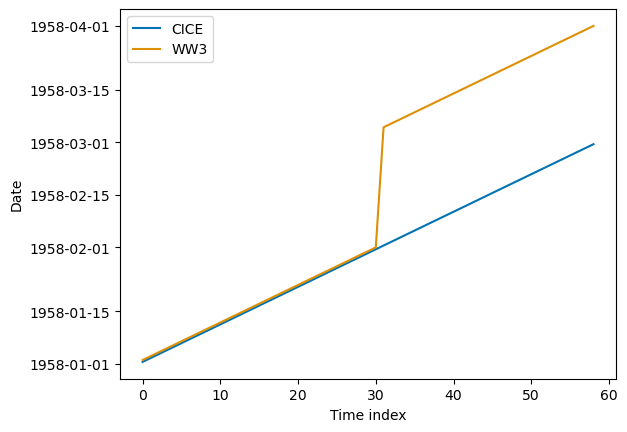

In [71]:
def describe_time_axis(name, time):
    diffs = np.diff(time.values).astype('timedelta64[h]').astype(float)
    print(f"{name}:")
    print(f"  Start: {time.values[0]}")
    print(f"  End:   {time.values[-1]}")
    print(f"  Length: {len(time)} steps")
    print(f"  Mean Δt: {np.mean(diffs):.2f} hours")
    print(f"  Unique Δt: {np.unique(diffs)} hours")
    print()

describe_time_axis("CICE", ds_cice.time)
describe_time_axis("WW3", ds_ww3.time)
# describe_time_axis("MOM6", ds_mom.time)

plt.plot(ds_cice.time, label='CICE')
plt.plot(ds_ww3.time, label='WW3')
plt.xlabel('Time index')
plt.ylabel('Date')
plt.legend()

In [72]:
# # ds_ww3.time.values
# ds_mom

# proj = ccrs.SouthPolarStereo()
# dims = [1,1]
# fig, axes, projection = basic_axis(dims)

# ds_plot_mom = ds_mom.isel(time=time_idx)
# ds_plot_mom[var].plot(ax=axes[0], x="lon", y="lat", 
#                         cmap=settings.get("cmap"),
#                         vmin=settings.get("vmin"),
#                         vmax=settings.get("vmax"),
#                         transform=ccrs.PlateCarree(),
# ) 

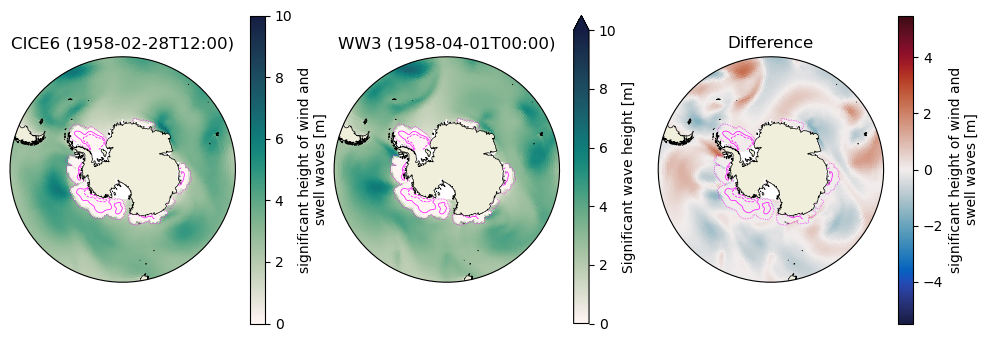

In [73]:
time_idx = -1
hemisphere="south"
ds_plot_cice = ds_cice.isel(time=time_idx)
ds_plot_ww3 = ds_ww3.isel(time=time_idx)

ww3_vars_dict = {
    "aice": "ICE",
    "wave_sig_ht": "HS",
    "fsdrad": "ICEF",
    "hi": "ICEH",
    "TLON": "lon",
    "TLAT": "lat"
}

var = 'wave_sig_ht'

proj = ccrs.SouthPolarStereo()
dims = [1,3]
fig, axes, projection = basic_axis(dims)

settings = get_plot_settings(var)

ds_plot_cice[var].plot(ax=axes[0], x="TLON", y="TLAT", 
                        cmap=settings.get("cmap"),
                        vmin=settings.get("vmin"),
                        vmax=settings.get("vmax"),
                        transform=ccrs.PlateCarree(),
) 

ds_plot_ww3 = ds_ww3.isel(time=time_idx)
ds_plot_ww3[ww3_vars_dict[var]].plot(ax=axes[1], x="lon", y="lat", 
                        cmap=settings.get("cmap"),
                        vmin=settings.get("vmin"),
                        vmax=settings.get("vmax"),
                        transform=ccrs.PlateCarree(),
) 

difference = ds_plot_ww3[ww3_vars_dict[var]].values - ds_plot_cice[var].values
ds_plot_cice[f'diff_{var}'] = ds_plot_cice[var]
ds_plot_cice[f'diff_{var}'].values = difference
ds_plot_cice[f'diff_{var}'].plot(ax=axes[2], x="TLON", y="TLAT", 
                        cmap=cmo.balance,
                        transform=ccrs.PlateCarree(),
) 


# --- Add ice contours ---
for ax in axes:
    add_ice_contours(ax, ds_plot_cice, hemisphere, projection)

# --- Add titles ---
time_str = str(ds_plot_cice['time'].values)[:16]  # Trim to readable format
axes[0].set_title(f"CICE6 ({time_str})")
time_str = str(ds_plot_ww3['time'].values)[:16]  # Trim to readable format
axes[1].set_title(f"WW3 ({time_str})")
axes[2].set_title("Difference")

fig.savefig(f"/home/566/nd0349/access-om3-analysis/figures/track_coupled_fields/{str(ds_plot_ww3['time'].values)[:10]}_{var}.png", dpi=300, bbox_inches='tight')
plt.show()


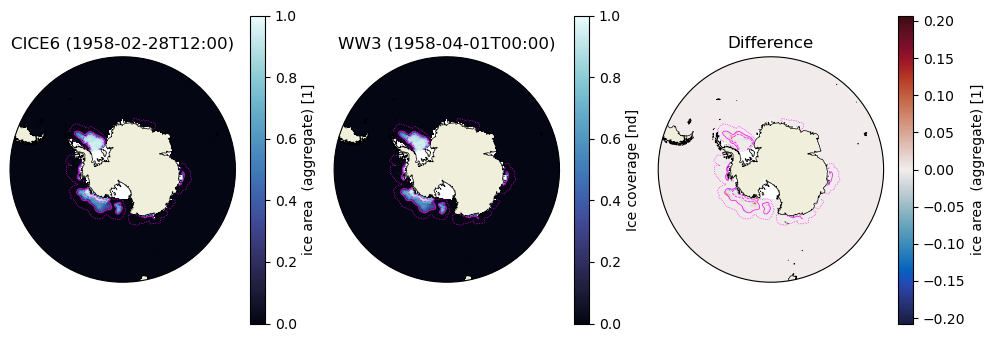

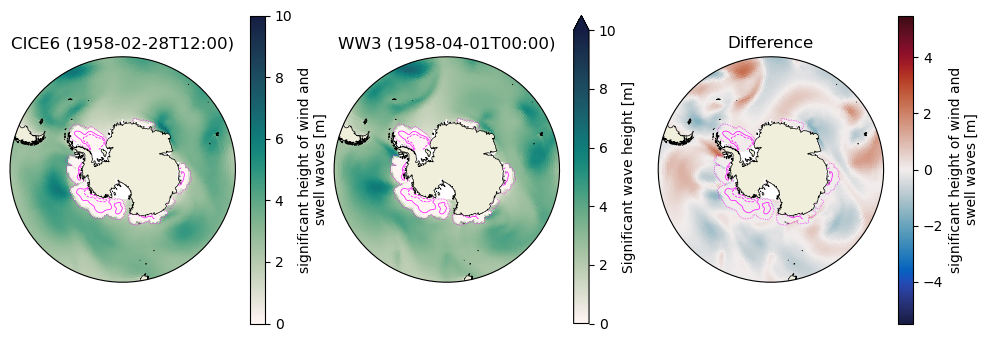

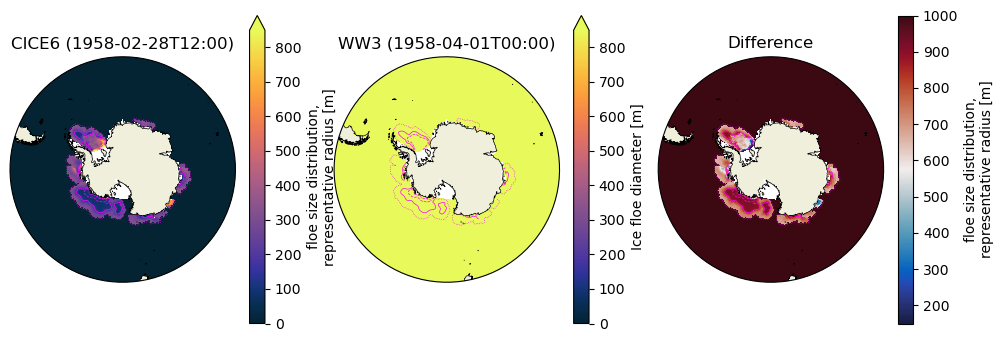

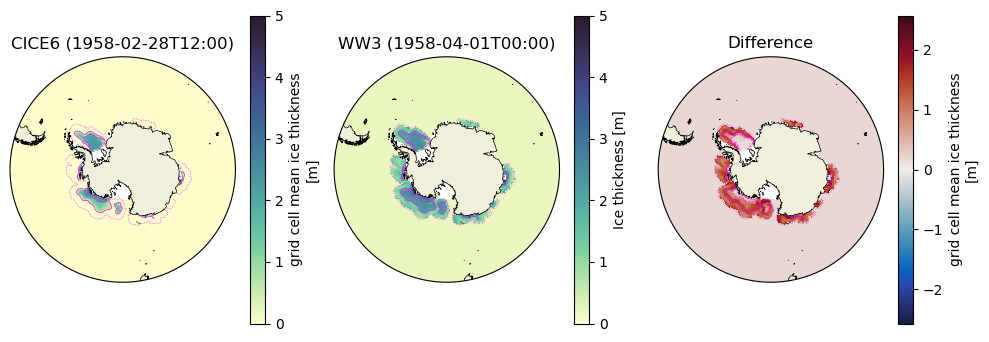

In [74]:
# time_idx = 100

ds_plot_cice = ds_cice.isel(time=time_idx)
ds_plot_ww3 = ds_ww3.isel(time=time_idx)

ww3_vars_dict = {
    "aice": "ICE",
    "wave_sig_ht": "HS",
    "fsdrad": "ICEF",
    "hi": "ICEH",
    "TLON": "lon",
    "TLAT": "lat"
}

for var in ["aice", "wave_sig_ht", "fsdrad", "hi"]:
    proj = ccrs.SouthPolarStereo()
    dims = [1,3]
    fig, axes, projection = basic_axis(dims)
    
    settings = get_plot_settings(var)
    
    ds_plot_cice[var].plot(ax=axes[0], x="TLON", y="TLAT", 
                            cmap=settings.get("cmap"),
                            vmin=settings.get("vmin"),
                            vmax=settings.get("vmax"),
                            transform=ccrs.PlateCarree(),
    ) 
    
    ds_plot_ww3 = ds_ww3.isel(time=time_idx)
    ds_plot_ww3[ww3_vars_dict[var]].plot(ax=axes[1], x="lon", y="lat", 
                            cmap=settings.get("cmap"),
                            vmin=settings.get("vmin"),
                            vmax=settings.get("vmax"),
                            transform=ccrs.PlateCarree(),
    ) 
    
    difference = ds_plot_ww3[ww3_vars_dict[var]].values - ds_plot_cice[var].values
    ds_plot_cice[f'diff_{var}'] = ds_plot_cice[var]
    ds_plot_cice[f'diff_{var}'].values = difference
    ds_plot_cice[f'diff_{var}'].plot(ax=axes[2], x="TLON", y="TLAT", 
                            cmap=cmo.balance,
                            transform=ccrs.PlateCarree(),
    ) 
    
    
    # --- Add ice contours ---
    for ax in axes:
        add_ice_contours(ax, ds_plot_cice, hemisphere, projection)
    
    # --- Add titles ---
    time_str = str(ds_plot_cice['time'].values)[:16]  # Trim to readable format
    axes[0].set_title(f"CICE6 ({time_str})")
    time_str = str(ds_plot_ww3['time'].values)[:16]  # Trim to readable format
    axes[1].set_title(f"WW3 ({time_str})")
    axes[2].set_title("Difference")
    
    fig.savefig(f"/home/566/nd0349/access-om3-analysis/figures/track_coupled_fields/{str(ds_plot_ww3['time'].values)[:10]}_{var}.png", dpi=300, bbox_inches='tight')
    plt.show()


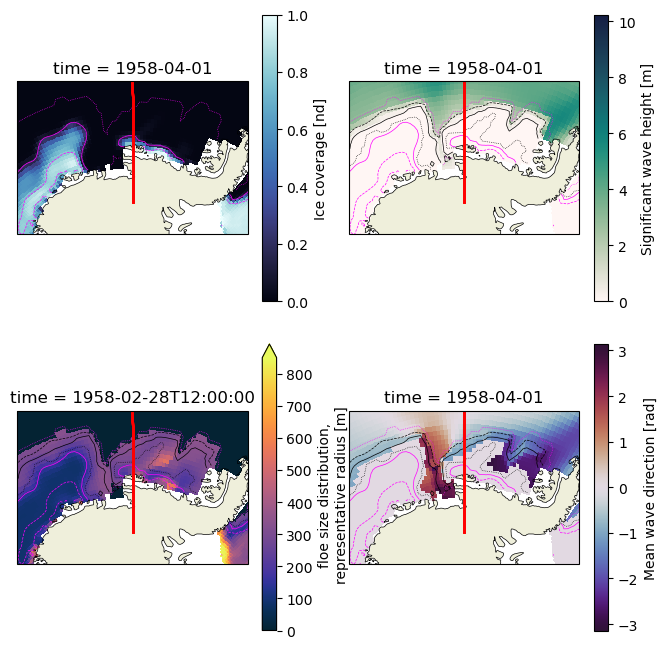

In [75]:
# region_extent = [30, 60, -72, -55]
nx_idx = 180
region_extent = [ds_ww3['lon'].isel(nx=nx_idx)[0].values-30, 
                 ds_ww3['lon'].isel(nx=nx_idx)[0].values+30, 
                 -80, 
                 -65]

# PLOT FOR A REGION
hemisphere = "regional"
shape = "rectangular"
# Slice time
ds_plot = ds_ww3.isel(time=time_idx)

# Setup polar projection
proj = proj = ccrs.Stereographic(central_latitude=(region_extent[2] + region_extent[3])/2, 
                                 central_longitude=(region_extent[0] + region_extent[1])/2)
dims = [2,2]
fig, axes, projection = basic_axis(dims, hemisphere=hemisphere, projection=proj, shape=shape)

# Plot ICE on the map
settings = get_plot_settings("ICE")

ds_plot["ICE"].plot(ax=axes[0], x="lon", y="lat", 
                      # cmap=settings.get("cmap"),
                      # vmin=settings.get("vmin"),
                      # vmax=settings.get("vmax"),
                    cmap=cmo.ice,
                    transform=ccrs.PlateCarree(),
) 

cs = add_ice_contours(axes[0], ds_plot, hemisphere, projection)


ds_plot["HS"].plot(ax=axes[1], x="lon", y="lat", 
                      # cmap=settings.get("cmap"),
                      # vmin=settings.get("vmin"),
                      # vmax=settings.get("vmax"),
                    cmap=cmo.tempo,
                    transform=ccrs.PlateCarree(),
) 

cs = add_ice_contours(axes[1], ds_plot, hemisphere, projection)
cs2 = add_swh_contours(axes[1], ds_plot, hemisphere, projection)

if (ATTEN_OPT == "IC4M2") or (ATTEN_OPT == "IC4M6"):
    settings = get_plot_settings("fsdrad")
    ds_plot_cice["fsdrad"].plot(ax=axes[2], x="TLON", y="TLAT", 
                        cmap=settings.get("cmap"),
                        vmin=settings.get("vmin"),
                        vmax=settings.get("vmax"),
                        transform=ccrs.PlateCarree(),
    ) 
else:
    ds_plot["ICEF"].plot(ax=axes[2], x="lon", y="lat", 
                          # cmap=settings.get("cmap"),
                          # vmin=settings.get("vmin"),
                          # vmax=settings.get("vmax"),
                        cmap=cmo.tempo,
                        transform=ccrs.PlateCarree(),
    ) 
cs = add_ice_contours(axes[2], ds_plot, hemisphere, projection)
cs2 = add_swh_contours(axes[2], ds_plot, hemisphere, projection)

# zero degrees representing waves coming from the north
theta_rad = ds_plot["THM"].values # - np.pi #𝜋 # We subtract pi so that 
arrow_mag = ds_plot["HS"].values
U = arrow_mag * np.cos(theta_rad)  # x-component (longitude)
V = arrow_mag * np.sin(theta_rad)  # y-component (latitude)

# Subsample the data for plotting arrows (too many arrows can clutter the plot)
stride = 2  # plot every 5th point
lon_quiver = ds_plot['lon'].values[::stride, ::stride]
lat_quiver = ds_plot['lat'].values[::stride, ::stride]
U_quiver = U[::stride, ::stride]
V_quiver = V[::stride, ::stride]

# Plot background mean direction
ds_plot["THM"].plot(ax=axes[3], x="lon", y="lat", 
                    cmap='twilight_shifted',
                    transform=ccrs.PlateCarree()
)

cs = add_ice_contours(axes[3], ds_plot, hemisphere, projection)
cs2 = add_swh_contours(axes[3], ds_plot, hemisphere, projection)

# # Add coastlines and grid
# ax.coastlines()
# ax.gridlines(draw_labels=False, linestyle="--", alpha=0.5)

# --- Add red line at nx_idx ---
# If nx is an index along longitude:
lats = ds_plot["lat"].isel(nx=nx_idx)
lons = ds_plot["lon"].isel(nx=nx_idx)

for ax in axes:
    ax.plot(
        lons, lats,
        color="red",
        linewidth=2,
        transform=ccrs.PlateCarree(),
        label=f"nx={nx_idx}"
    )
    # ax.legend()

# plt.legend()
# plt.show()
# Define your region bounds (lon_min, lon_max, lat_min, lat_max)


for ax in axes:
    # Limit to your region in PlateCarree
    ax.set_extent(region_extent, crs=ccrs.PlateCarree())
    
    # Add red line at nx_idx
    ax.plot(
        lons, lats,
        color="red",
        linewidth=2,
        transform=ccrs.PlateCarree(),
        label=f"nx={nx_idx}"
    )

t = ds_plot['time']
t_str = np.datetime_as_string(t, unit='D').replace('-', '')
# plt.savefig(f"/home/566/nd0349/access-om3-analysis/figures/regional_basic_plot_{EXPT}_{t_str}.png", dpi=600)
plt.show()

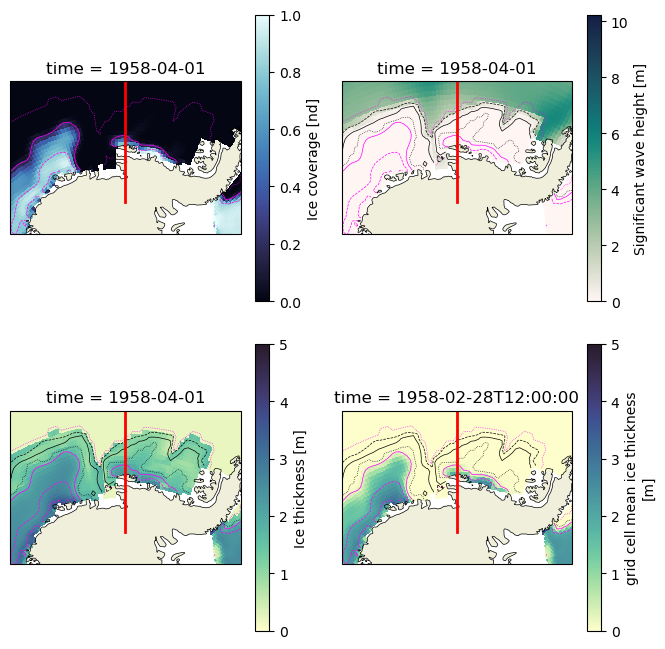

In [76]:
# PLOT FOR A REGION
hemisphere = "regional"
shape = "rectangular"
# Slice time
ds_plot = ds_ww3.isel(time=time_idx)

# Setup polar projection
proj = proj = ccrs.Stereographic(central_latitude=(region_extent[2] + region_extent[3])/2, 
                                 central_longitude=(region_extent[0] + region_extent[1])/2)
dims = [2,2]
fig, axes, projection = basic_axis(dims, hemisphere=hemisphere, projection=proj, shape=shape)

# Plot ICE on the map
settings = get_plot_settings("ICE")

ds_plot["ICE"].plot(ax=axes[0], x="lon", y="lat", 
                      # cmap=settings.get("cmap"),
                      # vmin=settings.get("vmin"),
                      # vmax=settings.get("vmax"),
                    cmap=cmo.ice,
                    transform=ccrs.PlateCarree(),
) 

cs = add_ice_contours(axes[0], ds_plot, hemisphere, projection)


ds_plot["HS"].plot(ax=axes[1], x="lon", y="lat", 
                      # cmap=settings.get("cmap"),
                      # vmin=settings.get("vmin"),
                      # vmax=settings.get("vmax"),
                    cmap=cmo.tempo,
                    transform=ccrs.PlateCarree(),
) 

cs = add_ice_contours(axes[1], ds_plot, hemisphere, projection)
cs2 = add_swh_contours(axes[1], ds_plot, hemisphere, projection)








# Plot ice thickness on the map
settings = get_plot_settings("hi")

ds_plot["ICEH"].plot(ax=axes[2], x="lon", y="lat", 
                    cmap=settings.get("cmap"),
                    vmin=settings.get("vmin"),
                    vmax=settings.get("vmax"),
                    transform=ccrs.PlateCarree(),
) 

cs = add_ice_contours(axes[2], ds_plot, hemisphere, projection)
cs2 = add_swh_contours(axes[2], ds_plot, hemisphere, projection)

ds_plot_cice["hi"].plot(ax=axes[3], x="TLON", y="TLAT", 
                    cmap=settings.get("cmap"),
                    vmin=settings.get("vmin"),
                    vmax=settings.get("vmax"),
                    transform=ccrs.PlateCarree(),
) 

cs = add_ice_contours(axes[3], ds_plot, hemisphere, projection)
cs2 = add_swh_contours(axes[3], ds_plot, hemisphere, projection)



# --- Add red line at nx_idx ---
# If nx is an index along longitude:
lats = ds_plot["lat"].isel(nx=nx_idx)
lons = ds_plot["lon"].isel(nx=nx_idx)

for ax in axes:
    ax.plot(
        lons, lats,
        color="red",
        linewidth=2,
        transform=ccrs.PlateCarree(),
        label=f"nx={nx_idx}"
    )

for ax in axes:
    # Limit to your region in PlateCarree
    ax.set_extent(region_extent, crs=ccrs.PlateCarree())
    # ax.plot(
    #     lons, lats,
    #     color="red",
    #     linewidth=2,
    #     transform=ccrs.PlateCarree(),
    #     label=f"nx={nx_idx}"
    # )

t = ds_plot['time']
t_str = np.datetime_as_string(t, unit='D').replace('-', '')
# plt.savefig(f"/home/566/nd0349/access-om3-analysis/figures/regional_basic_plot_{EXPT}_{t_str}.png", dpi=600)
plt.show()

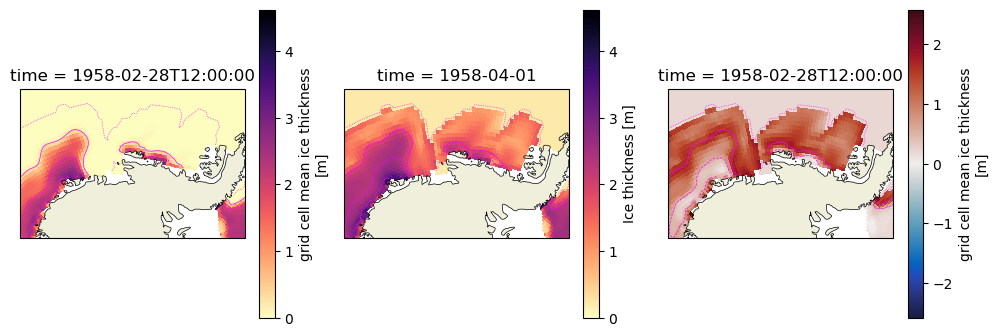

In [77]:
ww3_vars_dict = {
    "aice": "ICE",
    "wave_sig_ht": "HS",
    "fsdrad": "ICEF",
    "hi": "ICEH",
    "TLON": "lon",
    "TLAT": "lat"
}

var = 'hi'

# PLOT FOR A REGION
hemisphere = "regional"
shape = "rectangular"
# Slice time
ds_plot = ds_ww3.isel(time=time_idx)

# Setup polar projection
proj = ccrs.Stereographic(central_latitude=(region_extent[2] + region_extent[3])/2, 
                                 central_longitude=(region_extent[0] + region_extent[1])/2)
dims = [1, 3]
fig, axes, projection = basic_axis(dims, hemisphere=hemisphere, projection=proj, shape=shape)

settings = get_plot_settings(var)

ds_plot_cice[var].plot(ax=axes[0], x="TLON", y="TLAT", 
                        cmap='magma_r',
                        vmin=ds_plot_cice[var].min().values,
                        vmax=ds_plot_ww3[ww3_vars_dict[var]].max().values,
                        transform=ccrs.PlateCarree(),
) 

ds_plot_ww3 = ds_ww3.isel(time=time_idx)
ds_plot_ww3[ww3_vars_dict[var]].plot(ax=axes[1], x="lon", y="lat", 
                        cmap='magma_r',
                        vmin=ds_plot_cice[var].min().values,
                        vmax=ds_plot_ww3[ww3_vars_dict[var]].max().values,
                        transform=ccrs.PlateCarree(),
) 

difference = ds_plot_ww3[ww3_vars_dict[var]].values - ds_plot_cice[var].values
ds_plot_cice[f'diff_{var}'] = ds_plot_cice[var]
ds_plot_cice[f'diff_{var}'].values = difference
# xr_diff = (ds_plot_ww3[ww3_vars_dict[var]].values - ds_plot_cice[var]).compute()
ds_plot_cice[f'diff_{var}'].plot(ax=axes[2], x="TLON", y="TLAT", 
                        cmap=cmo.balance,
                        # vmin=settings.get("vmin"),
                        # vmax=settings.get("vmax"),
                        transform=ccrs.PlateCarree(),
) 




cs = add_ice_contours(axes[0], ds_plot_cice, hemisphere, projection)
# cs = add_swh_contours(axes[0], ds_plot_ww3, hemisphere, projection)
cs = add_ice_contours(axes[1], ds_plot_cice, hemisphere, projection)
# cs = add_swh_contours(axes[1], ds_plot_ww3, hemisphere, projection)
cs = add_ice_contours(axes[2], ds_plot_cice, hemisphere, projection)

for ax in axes:
    ax.set_extent(region_extent, crs=ccrs.PlateCarree())


In [78]:
print(ds_plot_ww3[ww3_vars_dict[var]].min().values)

0.2


In [79]:
print(np.nanmin(ds_plot_ww3[ww3_vars_dict[var]].values))

0.2
